# From Notebook to Production Code 

In [1]:
import argparse
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import RandomCrop, RandomRotation

%matplotlib inline

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()  # run initializer on the parent class

        # Convolutional Layers
        # 1 image, 6 output channels, 5x5 convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        """
        forward must be overwritten in torch model class
        """
        # Convolutional Layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # add pooling layers
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 256)  # flatten to pass to fully connected layers

        # fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [3]:
def load_data(training=True):
    transform_ = transforms.Compose([
        RandomRotation(45),
        RandomCrop(28),
        transforms.ToTensor(),
    ])
    data = torchvision.datasets.MNIST(
        root='./data/',
        train=training,
        download=True,
        transform=transform_,
    )
    loader = torch.utils.data.DataLoader(
        data,
        batch_size=16,
        shuffle=True,
        num_workers=2,
    )

    return loader

In [4]:
results = defaultdict(list)

model = LeNet()
print(model)

dataloader = load_data()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(3):
    steps = []
    losses = []
    accuracies = []

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(dataloader):
        # wrap features as torch Variables
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels)  # optimization
        loss.backward()  # compute back propagation
        optimizer.step()  # update model parameters

        running_loss += loss.data[0]

        if i % 50 == 49:  # print every 100 mini-batches
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
            accuracy = 100. * correct / total

            steps.append(i+1)
            losses.append(running_loss/100)
            accuracies.append(accuracy)

            running_loss = 0.0  # zero the loss
    
    # add observations to the dictionary
    results['step'] += steps
    results['loss_scores'] += losses
    results['acc_scores'] += accuracies
    results['epoch'] += [epoch+1] * len(steps)

LeNet(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128)
  (fc2): Linear(in_features=128, out_features=64)
  (fc3): Linear(in_features=64, out_features=10)
)


In [5]:
df = pd.DataFrame.from_dict(results)

In [6]:
df.tail(5)

,acc_scores,epoch,loss_scores,step
220,96.654930,3,0.047259,3550
221,96.614583,3,0.048467,3600
222,96.660959,3,0.051463,3650
223,96.706081,3,0.056395,3700
224,96.750000,3,0.050140,3750


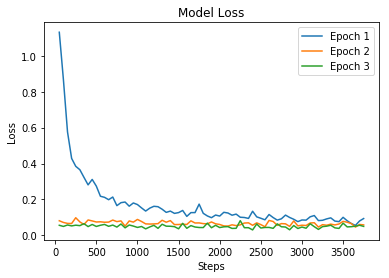

In [7]:
fig, ax = plt.subplots()
epochs = df.groupby('epoch')
for epoch, data in epochs:
    ax.plot(data['step'], data['loss_scores'], label='Epoch %d' % epoch)
ax.legend(numpoints=1, loc='upper right')
ax.set(xlabel="Steps", ylabel="Loss", title="Model Loss");

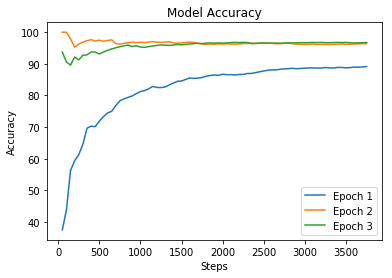

In [8]:
fig, ax = plt.subplots()
epochs = df.groupby('epoch')
for epoch, data in epochs:
    ax.plot(data['step'], data['acc_scores'], label='Epoch %d' % epoch)
ax.legend(numpoints=1, loc='lower right')
ax.set(xlabel="Steps", ylabel="Accuracy", title="Model Accuracy");